# Perkenalan

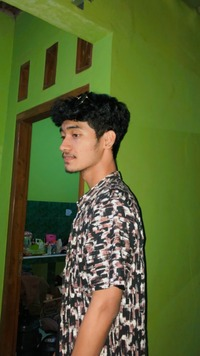

Nama : Fitrah Saputra,
Bergabung sejak 21 Sep 2021,
Alamat :  Kota Bandar Lampung, Lampung

In [375]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [376]:
df = pd.read_csv('Summary of Weather.csv')
df = df.drop(columns=[
    'STA', 'Precip', 'WindGustSpd', 'Snowfall', 'PoorWeather', 
    'YR', 'MO', 'DA', 'PRCP', 'DR', 'SPD', 'MAX', 'MIN', 'MEA',
    'SNF', 'SND', 'FT', 'FB', 'FTI', 'ITH', 'PGT', 'TSHDSBRSGF',
    'SD3', 'RHX', 'RHN', 'RVG', 'WTE'
])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119040 entries, 0 to 119039
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Date      119040 non-null  object 
 1   MaxTemp   119040 non-null  float64
 2   MinTemp   119040 non-null  float64
 3   MeanTemp  119040 non-null  float64
dtypes: float64(3), object(1)
memory usage: 3.6+ MB


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7,8,18,25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [377]:
df.head()

,Date,MaxTemp,MinTemp,MeanTemp
0,1942-7-1,25.555556,22.222222,23.888889
1,1942-7-2,28.888889,21.666667,25.555556
2,1942-7-3,26.111111,22.222222,24.444444
3,1942-7-4,26.666667,22.222222,24.444444
4,1942-7-5,26.666667,21.666667,24.444444


In [378]:
df.isnull().sum()

Date        0
MaxTemp     0
MinTemp     0
MeanTemp    0
dtype: int64

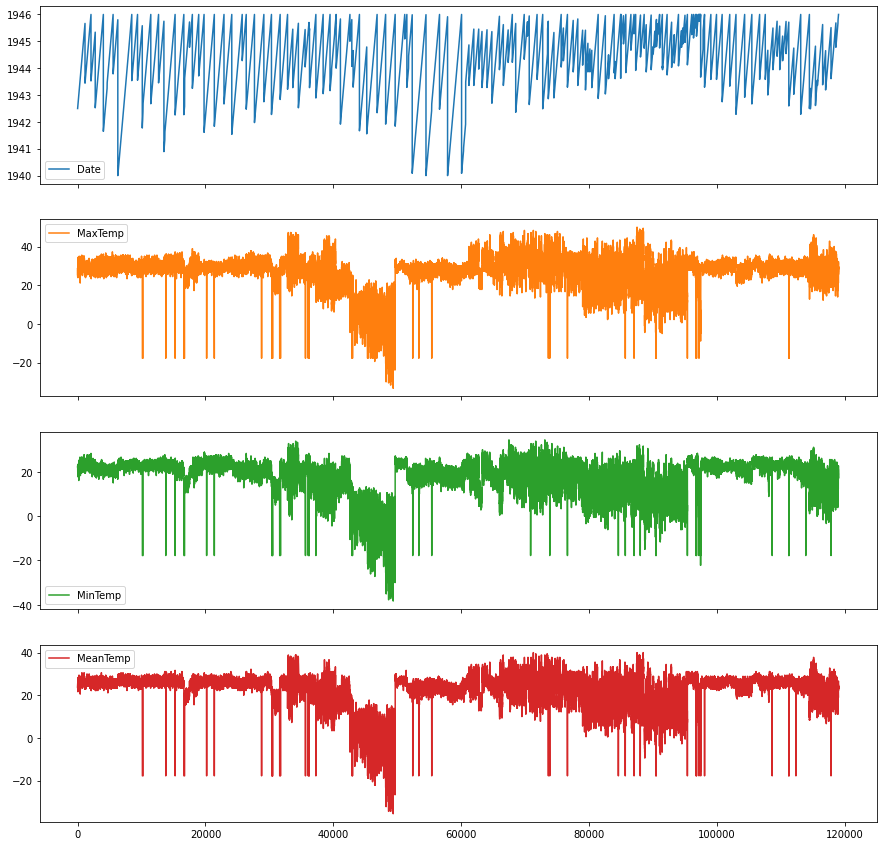

Text(0.5, 1.0, 'Temperature Average')

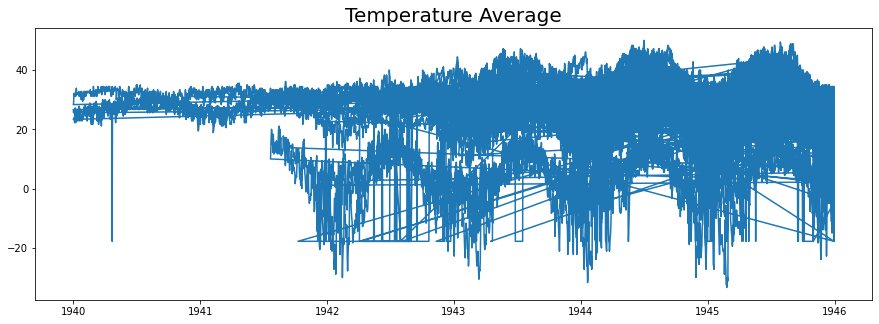

In [386]:
df['Date']=df['Date'].astype(np.datetime64)

dates = df['Date'].values
temp = df['MaxTemp'].values

df[df.columns.to_list()].plot(subplots=True, figsize=(15, 15))
plt.show()

print('\n')

plt.figure(figsize=(15, 5))
plt.plot(dates, temp)
plt.title('Temperature Average', fontsize=20)

In [380]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(temp, dates, test_size=0.2, shuffle=False)

print('Jumlah Data Train : ', len(x_train))
print('Jumlah Data Validation : ', len(x_valid))

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w : w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w : (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

Jumlah Data Train :  95232
Jumlah Data Validation :  23808


In [381]:
train_set = windowed_dataset(
    x_train,
    window_size=60,
    batch_size=100, 
    shuffle_buffer=1000
)

val_set = windowed_dataset(
    x_valid, 
    window_size=60, 
    batch_size=100, 
    shuffle_buffer=1000
)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [382]:
Mae = (df['MaxTemp'].max() - df['MaxTemp'].min()) * 10/100
print(Mae)

8.333333333


In [383]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < Mae and logs.get('val_mae') < Mae):
      print("\nNilai MAE sudah mencapai < 10% skala data")
      self.model.stop_training=True
      
callbacks = myCallback()

In [384]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

history = model.fit(
    train_set, 
    epochs=100, 
    validation_data=val_set, 
    verbose=2,
    callbacks=[callbacks]
)

Epoch 1/100
952/952 - 59s - loss: 13.8723 - mae: 14.3519 - val_loss: 0.8967 - val_mae: 1.2953 - 59s/epoch - 62ms/step
Epoch 2/100

Nilai MAE sudah mencapai < 10% skala data
952/952 - 51s - loss: 1.3964 - mae: 1.8104 - val_loss: 0.8247 - val_mae: 1.2123 - 51s/epoch - 53ms/step


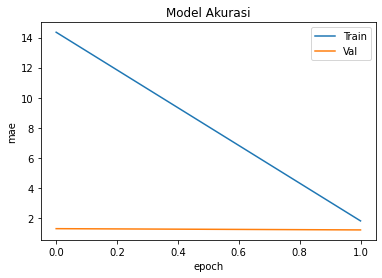

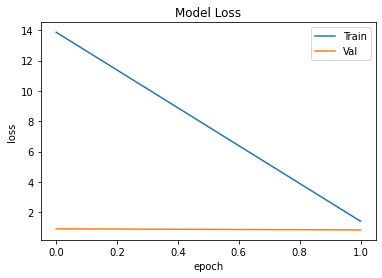

In [387]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Akurasi')
plt.xlabel('epoch')
plt.ylabel('mae')
plt.legend(['Train', 'Val'], loc='best')
plt.show()

print('\n')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Val'], loc='best')
plt.show()